# Comparison of Different Algorithmic Trading Strategies on Tesla Stock Price

### Tawfiq Jawhar
<b>Machine Learning (COMP-652 and ECSE-608)<br>
Fall 2018<br>
McGill University <br><br>
Instructors:<br>
Audrey Durand<br>
Riashat Islam <br></b>

---

## Outline
SMA by itself was a risky strategy that was not able to do well on the TSLA stock price. We will combine SMA with Exponential Moving Average (EMA). The exponential moving average is similar to the simple moving average but it gives a higher weight for the most recent prices depending on the number of periods in the moving average.

EMA for period t is calculated as follow:

$$ EMA_t=\left\{
                \begin{array}{ll}
                  Y_1\quad \quad \quad \quad\quad\quad\quad \quad\quad\quad t=1\\
                  \alpha\cdot Y_t + (1-\alpha)\cdot EMA_{t-1} \quad\quad t>1\\
                \end{array}
              \right. $$
              
Where $ Y_t $ is the price value at time period $t$. [source](https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average)

We will use EMA from TA-lib.

## SEMA - Simple and Exponential Moving Average Strategy
The SE-MA strategy is similar to SMA strategy. We calculate $ SMA_{short} $, $ SMA_{long} $, $EMA_{short}$, and $EMA_{long}$. 
```
IF SMA_short > SMA_long AND EMA_short > EMA_long THEN
    IF NOT Invested THEN
        BUY
ELSE IF SMA_long > SMA_short OR EMA_long > EMA_long THEN
    IF Invested THEN
        SELL
```
If both SMA and EMA makes a decision of buying then the strategy will buy. If any of the moving averages indicate selling then the strategy will sell. 

Similar to what we did with SMA, we will use Bayesian Optimization to optimize for the short and long parameters for SMA and EMA. 

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;
//to show the full output without scrolling

<IPython.core.display.Javascript object>

In [2]:
## to use zipline magic commands (which is not used in this notebook)
%load_ext zipline
## inline plot
%matplotlib inline

##import libraries
import zipline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
plt.style.use('seaborn-darkgrid')
#plt.style.use('bmh')

import pickle
import numpy as np
from zipline.api import (
    order_target_percent, 
    record, 
    symbol, 
    schedule_function, 
    sid,
    date_rules,
    time_rules,
    get_open_orders,
    order_percent,
    order,
    set_benchmark)
from zipline.finance import commission, slippage
from zipline import run_algorithm

## pyfolio was not installed in the docker image (needs updating)
## if you want to use pyfolio to analyze the portfolio
try:
    import pyfolio as pf
except:    
    !pip install pyfolio
    import pyfolio as pf
from bayes_opt import BayesianOptimization

import matplotlib.pyplot as plt
## Technical Analysis Library
from talib import EMA

In [3]:
## Dictionary to hold environment information.
env = {
    'train': {
        'start_time': pd.to_datetime('2014-01-01').tz_localize('US/Eastern'),
        'end_time': pd.to_datetime('2015-12-31').tz_localize('US/Eastern')
    },
    'test': {
        'start_time': pd.to_datetime('2016-01-01').tz_localize('US/Eastern'),
        'end_time': pd.to_datetime('2017-12-31').tz_localize('US/Eastern')
    },
    'commision': None, #commission.PerShare(cost=.0075, min_trade_cost=1.0)
    'slippage': None, #slippage.VolumeShareSlippage()
    'capital': 100000, #USD
    'stock': 'TSLA',
    'date_rules': date_rules.every_day(),
    'time_rules': time_rules.market_open()
}

In [4]:
## ESMA parameters
param = {
    'SMA_short' : 5,
    'SMA_long'  : 10,
    'EMA_short' : 5,
    'EMA_long'  : 10
}

In [5]:
## Zipline strategy implementation
def analyze(context=None, results=None):
    fig = plt.figure(figsize=(10,15))
    ax1 = plt.subplot2grid((6,3),(0,0),colspan=3,rowspan=2)
    results.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('Portfolio value (USD)')

    ax2 = plt.subplot2grid((6,3),(2,0),colspan=3,rowspan=2)
    ax2.set_ylabel('Price (USD)')

  # If data has been record()ed, then plot it.
    # Otherwise, log the fact that no data has been recorded.
    if env['stock'] in results and 'sma_long' in results and 'sma_short' in results\
    and 'ema_short' in results and 'ema_long' in results:
        results[['TSLA', 'sma_long', 'sma_short','ema_long','ema_short']].plot(ax=ax2)

        ax2.plot(
            results.index[results.buy],
            results.loc[results.buy, 'TSLA'],
            '^',
            markersize=10,
            color='m',
            label ='buy',
        )
        ax2.plot(
            results.index[results.sell],
            results.loc[results.sell, 'TSLA'],
            'v',
            markersize=10,
            color='k',
            label='sell',
        )
        plt.legend(loc=0)
    else:
        msg = env['stock']+' data not captured using record().'
        ax2.annotate(msg, xy=(0.1, 0.5))
    #ticks = ax2.get_xticks()
    #labels = ax2.get_xticklabels()
    #ax1.get_shared_x_axes().join(ax1, ax2)
    #ax2.set_xticks(ticks)
    #ax2.set_xticklabels(labels)
    ax3 = plt.subplot2grid((6,3),(4,0),colspan=3,rowspan=1)
    ax3.set_ylabel('Sharpe Ratio')
    results.sharpe.plot(ax=ax3)
    bottom, top = ax3.get_ylim()
   
    ax3.set_ylim(-3,top)
    
    ax4 = plt.subplot2grid((6,3),(5,0),colspan=1,rowspan=1)
    ax4.set_ylabel("leverage")
    results.leverage.plot(ax=ax4)
    every_nth = 4
    for n, label in enumerate(ax4.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

    ax5 = plt.subplot2grid((6,3),(5,1),colspan=2,rowspan=1)
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
    pf.plot_monthly_returns_heatmap(returns,ax=ax5)
    plt.tight_layout()
    plt.show()

    
def initialize(context):
    context.invested = False
    context.asset = symbol(env['stock'])
    context.set_commission(env['commision'])
    context.set_slippage(env['slippage'])
    schedule_function(handle_data_daily, env['date_rules'], env['time_rules'])
    

#Daily price history XXXXXXX
def handle_data_daily(context, data):
    hist = data.history(
        context.asset, 
        fields= 'price', 
        bar_count=param['SMA_long'], 
        frequency='1d'
    )
    
    hist[param['SMA_long']-1]=data.current(context.asset,'open')
    ## Calculate SMA(N) and SMA(M)
    sma_long = hist.mean()
    sma_short = hist[-param['SMA_short']:].mean()
    
    hist = data.history(
        context.asset, 
        fields= 'price', 
        bar_count=param['EMA_long'], 
        frequency='1d'
    )
    
    hist[param['EMA_long']-1]=data.current(context.asset,'open')
   
    ema_short = EMA(hist.values, timeperiod=param['EMA_short'])
    ema_long = EMA(hist.values, timeperiod=param['EMA_long'])
    

    buy = False
    sell = False
     #If no open orders, balance 100% of portfolio to TSLA & 
     #execute scheduled market order if SMA and EMA will buy. 
    if sma_short > sma_long and ema_short[-1] > ema_long[-1] and not context.invested:
        order_percent(context.asset, 1.0)
        context.invested = True
        buy=True
    #If no open orders, short sell 100% of portfolio of TSLA & 
    #execute scheduled market order if SMA or EMA will sell. 
    elif context.invested and (sma_long > sma_short  or ema_long[-1] > ema_short[-1]): 
        order_percent(context.asset, -1.0)
        context.invested = False
        sell=True
    #Record results
    record(TSLA=data.current(context.asset, "price"),
           sma_long=sma_long,
           sma_short=sma_short,
           ema_long=ema_long[-1],
           ema_short=ema_short[-1],
           buy=buy,
           sell=sell)
    record(leverage=context.account.leverage)


## Objective Function

We will use similar objective function that we used in optimizing SMA strategy. To make sure our optimization is not over fitting on the training set, the objective function will run the backtesting on 4 different time periods (6 months each). And the objective value will be the sum of the 4 sharpe ratios for every time period.
We will set the range of short SMA [1,10], short EMA [2,10] and long SMA and EMA [11,60].

We have 225 000 possible combinations (10 SMA short, 9 EMA short, 50 SMA long and 50 SMA short). 
We will initialize with 10 points and then run the optimization 500 runs. 

In [6]:
## objective function
## Input new parameters for short and long and run the strategy
## return the sharpe ratio at the end of the trading period
period = [(pd.to_datetime('2014-01-01').tz_localize('US/Eastern'),pd.to_datetime('2014-06-30').tz_localize('US/Eastern')),
         (pd.to_datetime('2014-07-01').tz_localize('US/Eastern'),pd.to_datetime('2014-12-31').tz_localize('US/Eastern')),
         (pd.to_datetime('2015-01-01').tz_localize('US/Eastern'),pd.to_datetime('2015-06-30').tz_localize('US/Eastern')),
         (pd.to_datetime('2015-07-01').tz_localize('US/Eastern'),pd.to_datetime('2015-12-31').tz_localize('US/Eastern'))]
            
def objective(sma_short, sma_long, ema_short, ema_long):
    param['SMA_short'] = int(round(sma_short))
    param['SMA_long'] = int(round(sma_long))
    param['EMA_short'] = int(round(ema_short))
    param['EMA_long'] = int(round(ema_long))
    sharpe = 0
    for i in period:
        results = run_algorithm(i[0], i[1],
                        initialize=initialize,capital_base=env['capital'])    
        sharpe += results.sharpe[-1]
    return sharpe


In [7]:
kappa=5
##initialize
bo = BayesianOptimization(objective, {'sma_short': (1, 10),'sma_long': (11,60),
                                      'ema_short':(2,10), 'ema_long': (11,60)})
bo.maximize(init_points=10, n_iter=500, acq='ucb', kappa=kappa)


Initialization
-----------------------------------------------------------------------------------
 Step |   Time |      Value |   ema_long |   ema_short |   sma_long |   sma_short | 
    1 | 00m06s |    3.05738 |    19.2792 |      8.0395 |    33.3341 |      7.0834 | 
    2 | 00m05s |    3.00493 |    45.3809 |      8.9227 |    50.9598 |      6.5394 | 
    3 | 00m05s |    2.77281 |    33.0901 |      8.0514 |    58.2493 |      1.9375 | 
    4 | 00m05s |    1.04198 |    22.8036 |      2.8562 |    55.4711 |      2.7728 | 
    5 | 00m05s |    3.37838 |    19.7509 |      8.0464 |    42.6296 |      8.6131 | 
    6 | 00m05s |    2.55445 |    54.0903 |      4.1510 |    42.3464 |      1.9124 | 
    7 | 00m06s |    2.24090 |    17.6470 |      9.4142 |    23.0896 |      6.2552 | 
    8 | 00m05s |    3.63202 |    31.5525 |      7.1942 |    23.1757 |      6.4587 | 
    9 | 00m06s |    3.66773 |    52.8304 |      9.6132 |    12.4104 |      6.2775 | 
   10 | 00m05s |    2.44720 |    34.0307 |      2.5

   89 | 00m11s |    3.17802 |    58.9949 |     10.0000 |    46.5077 |      2.8494 | 
   90 | 00m11s |    4.33669 |    32.8898 |     10.0000 |    55.9540 |     10.0000 | 
   91 | 00m11s |    4.57772 |    22.7296 |      8.4306 |    50.7821 |     10.0000 | 
   92 | 00m11s |    2.77975 |    23.6211 |      3.9410 |    48.3013 |     10.0000 | 
   93 | 00m11s |    4.04351 |    17.5718 |     10.0000 |    51.7754 |     10.0000 | 
   94 | 00m11s |    3.01831 |    21.7875 |     10.0000 |    49.5386 |      5.3803 | 
   95 | 00m11s |    4.90446 |    21.8321 |     10.0000 |    55.9758 |     10.0000 | 
   96 | 00m11s |    4.25376 |    20.0716 |      6.0596 |    55.2655 |     10.0000 | 
   97 | 00m14s |    4.23651 |    17.5745 |     10.0000 |    60.0000 |     10.0000 | 
   98 | 00m14s |    2.79208 |    21.4345 |     10.0000 |    60.0000 |      5.9888 | 
   99 | 00m13s |    4.72701 |    26.0925 |      7.8678 |    54.0817 |     10.0000 | 
  100 | 00m14s |    3.85575 |    12.3023 |      8.2265 |    57.34

  186 | 00m16s |    1.25587 |    11.0000 |      2.0000 |    59.8389 |     10.0000 | 
  187 | 00m16s |    4.04653 |    45.6589 |     10.0000 |    60.0000 |     10.0000 | 
  188 | 00m16s |    4.18098 |    17.8377 |      6.1109 |    60.0000 |     10.0000 | 
  189 | 00m16s |    4.65216 |    23.2584 |     10.0000 |    60.0000 |     10.0000 | 
  190 | 00m16s |    3.46941 |    52.7537 |     10.0000 |    34.7720 |     10.0000 | 
  191 | 00m17s |    3.61697 |    48.1382 |     10.0000 |    60.0000 |      1.0000 | 
  192 | 00m16s |    4.67910 |    60.0000 |      7.9297 |    18.4004 |      8.2068 | 
  193 | 00m16s |    4.15824 |    54.5600 |     10.0000 |    16.7654 |      7.4836 | 
  194 | 00m15s |    5.23581 |    44.2935 |      4.3959 |    57.4654 |     10.0000 | 
  195 | 00m15s |    3.36958 |    28.0035 |      6.6444 |    27.2125 |      5.4164 | 
  196 | 00m15s |    3.11025 |    34.2463 |      8.4208 |    24.6101 |     10.0000 | 
  197 | 00m16s |    2.27665 |    22.5202 |      4.3056 |    23.02

  282 | 00m17s |    3.46400 |    37.5554 |      5.5912 |    50.4627 |      6.1015 | 
  283 | 00m17s |    2.66451 |    20.7227 |      7.0874 |    38.4663 |      5.7493 | 
  284 | 00m17s |    2.38992 |    56.9673 |     10.0000 |    12.8982 |      6.5395 | 
  285 | 00m18s |    2.90531 |    50.1022 |      8.0888 |    15.1925 |      6.0717 | 
  286 | 00m17s |    1.96574 |    32.6939 |      4.4680 |    29.0119 |     10.0000 | 
  287 | 00m17s |    3.51242 |    24.5205 |      6.2469 |    26.6966 |     10.0000 | 
  288 | 00m17s |    2.60139 |    34.0538 |     10.0000 |    25.4834 |      4.2120 | 
  289 | 00m17s |    4.00555 |    26.3819 |      7.6237 |    50.8209 |     10.0000 | 
  290 | 00m17s |    4.35551 |    26.6803 |      2.0000 |    52.9805 |     10.0000 | 
  291 | 00m18s |    3.90587 |    23.9733 |      2.0000 |    60.0000 |      7.2828 | 
  292 | 00m17s |    4.29056 |    27.5903 |      5.1932 |    60.0000 |      7.1148 | 
  293 | 00m17s |    3.67195 |    30.9192 |     10.0000 |    60.00

  377 | 00m20s |    4.07831 |    25.1082 |      3.8405 |    58.3226 |      8.6372 | 
  378 | 00m21s |    3.65683 |    35.1013 |      7.0325 |    20.6837 |      7.6687 | 
  379 | 00m19s |    2.32624 |    21.4521 |      5.1584 |    44.8599 |      5.5317 | 
  380 | 00m20s |    4.02717 |    50.6812 |      4.5162 |    57.0395 |     10.0000 | 
  381 | 00m20s |    3.92173 |    57.5083 |     10.0000 |    37.3763 |     10.0000 | 
  382 | 00m19s |    4.48380 |    47.9356 |      2.0000 |    57.8073 |      8.5749 | 
  383 | 00m19s |    4.51782 |    47.9448 |      8.5225 |    57.2981 |     10.0000 | 
  384 | 00m20s |    5.44917 |    60.0000 |     10.0000 |    42.9661 |      8.4044 | 
  385 | 00m21s |    4.56310 |    59.5466 |      9.7293 |    45.3709 |      7.3823 | 
  386 | 00m20s |    4.75644 |    59.9499 |      9.0415 |    44.1972 |      9.4924 | 
  387 | 00m20s |    2.55221 |    56.4753 |      2.0000 |    43.8155 |      7.3516 | 
  388 | 00m21s |    4.32849 |    60.0000 |     10.0000 |    42.46

/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 3, 'grad': array([-0.00046222]), 'warnflag': 2, 'funcalls': 52}
  ConvergenceWarning)


  391 | 00m22s |    3.86088 |    28.0188 |      2.9694 |    60.0000 |      2.9932 | 
  392 | 00m21s |    3.06762 |    27.5920 |      7.0973 |    60.0000 |      2.0037 | 
  393 | 00m21s |    4.13487 |    32.2289 |      3.3876 |    60.0000 |      1.0000 | 
  394 | 00m20s |    2.39961 |    31.1404 |      2.0000 |    56.2932 |      1.0000 | 
  395 | 00m20s |    4.75644 |    60.0000 |     10.0000 |    42.2048 |     10.0000 | 
  396 | 00m20s |    2.68306 |    23.1321 |      6.3116 |    40.8499 |     10.0000 | 
  397 | 00m22s |    3.79814 |    60.0000 |     10.0000 |    36.9133 |      1.0000 | 
  398 | 00m21s |    2.30243 |    57.7091 |      5.3503 |    34.5471 |      1.0000 | 
  399 | 00m21s |    2.85643 |    60.0000 |      2.0000 |    27.4611 |      1.0000 | 


/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 4, 'grad': array([-0.00016268]), 'warnflag': 2, 'funcalls': 57}
  ConvergenceWarning)


  400 | 00m22s |    2.99583 |    60.0000 |      5.3351 |    43.7895 |      1.0000 | 
  401 | 00m21s |    4.45540 |    55.6964 |     10.0000 |    37.8101 |      3.7239 | 
  402 | 00m21s |    2.82653 |    29.5383 |      2.0000 |    41.9258 |      5.1552 | 
  403 | 00m22s |    3.01221 |    39.6372 |      6.6105 |    17.9859 |      8.2762 | 
  404 | 00m23s |    4.24337 |    13.8680 |      5.2642 |    57.5005 |     10.0000 | 
  405 | 00m20s |    3.82001 |    42.3104 |      7.6168 |    54.9056 |      7.3329 | 
  406 | 00m23s |    5.05878 |    60.0000 |     10.0000 |    40.8753 |      8.1899 | 
  407 | 00m20s |    2.04063 |    52.7849 |      2.0000 |    60.0000 |      6.3030 | 
  408 | 00m21s |    5.93467 |    59.0532 |      9.1528 |    17.4310 |     10.0000 | 
  409 | 00m22s |    2.01427 |    25.0055 |      2.0000 |    36.7434 |      6.4224 | 
  410 | 00m22s |    3.06553 |    44.5896 |      5.5834 |    45.3424 |      3.6672 | 
  411 | 00m22s |    3.84741 |    47.6196 |      2.5512 |    54.54

/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 4, 'grad': array([-0.00011936]), 'warnflag': 2, 'funcalls': 51}
  ConvergenceWarning)


  421 | 00m23s |    3.33931 |    25.8436 |      5.2058 |    27.5410 |      1.0000 | 
  422 | 00m21s |    4.20843 |    60.0000 |     10.0000 |    52.2467 |     10.0000 | 
  423 | 00m22s |    2.71744 |    41.2311 |      6.9698 |    48.8666 |      1.3101 | 
  424 | 00m22s |    2.73990 |    53.2500 |      6.6803 |    60.0000 |      1.0000 | 
  425 | 00m21s |    3.28545 |    26.9410 |      5.5191 |    23.3850 |      5.8643 | 
  426 | 00m24s |    2.19465 |    21.8037 |      5.0105 |    16.5788 |     10.0000 | 
  427 | 00m22s |    5.93467 |    58.6200 |      8.9654 |    16.8751 |     10.0000 | 
  428 | 00m21s |    1.16331 |    17.1176 |      4.6317 |    33.4903 |     10.0000 | 
  429 | 00m21s |    4.03931 |    45.5659 |      7.2130 |    53.6948 |     10.0000 | 
  430 | 00m23s |    3.37917 |    60.0000 |      2.0000 |    33.0827 |      5.4440 | 
  431 | 00m21s |    5.06707 |    23.4973 |      8.8897 |    55.0537 |     10.0000 | 
  432 | 00m22s |    4.77274 |    38.1836 |     10.0000 |    60.00

/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 5, 'grad': array([0.00110625]), 'warnflag': 2, 'funcalls': 51}
  ConvergenceWarning)


  463 | 00m28s |    3.48452 |    51.3817 |      7.9316 |    44.6673 |      7.5200 | 
  464 | 00m25s |    2.09469 |    13.9715 |      4.9342 |    52.5437 |      5.9226 | 
  465 | 00m24s |    2.84643 |    30.4824 |      6.2931 |    17.5975 |      6.5232 | 
  466 | 00m24s |    3.91670 |    22.6012 |      4.3571 |    55.2537 |     10.0000 | 
  467 | 00m25s |    4.93741 |    23.8008 |      8.1824 |    58.5414 |     10.0000 | 
  468 | 00m25s |    3.71707 |    41.1238 |      4.2704 |    60.0000 |      8.2081 | 
  469 | 00m25s |    4.03346 |    22.9338 |      2.0000 |    60.0000 |     10.0000 | 
  470 | 00m23s |    1.51462 |    57.2460 |      5.8938 |    53.6919 |      1.0000 | 
  471 | 00m23s |    2.39951 |    45.7328 |      7.3854 |    39.5094 |      5.9508 | 
  472 | 00m25s |    3.16196 |    39.9069 |     10.0000 |    50.4100 |      5.7801 | 
  473 | 00m24s |    2.73908 |    47.9690 |      4.1227 |    48.4606 |      1.0000 | 
  474 | 00m25s |    2.84264 |    52.6910 |     10.0000 |    57.76

/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 6, 'grad': array([0.00025037]), 'warnflag': 2, 'funcalls': 52}
  ConvergenceWarning)


  478 | 00m25s |    5.35363 |    58.5167 |      8.5065 |    43.0032 |      8.1983 | 
  479 | 00m23s |    4.77480 |    58.3447 |     10.0000 |    43.4970 |      8.3057 | 
  480 | 00m26s |    4.49692 |    60.0000 |      6.4298 |    42.7405 |      8.0864 | 
  481 | 00m24s |    2.30138 |    58.3241 |      6.4775 |    34.3551 |     10.0000 | 
  482 | 00m23s |    3.62729 |    29.2707 |      6.8181 |    54.6905 |     10.0000 | 
  483 | 00m24s |    3.36517 |    33.1352 |     10.0000 |    21.3976 |      7.9531 | 
  484 | 00m24s |    4.02514 |    22.5447 |     10.0000 |    21.5870 |      5.7492 | 
  485 | 00m23s |    2.34315 |    22.6206 |      8.6996 |    23.6287 |      2.5869 | 


/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 4, 'grad': array([0.00053163]), 'warnflag': 2, 'funcalls': 53}
  ConvergenceWarning)


  486 | 00m25s |    3.40552 |    21.3014 |      9.2177 |    22.0627 |      9.2462 | 
  487 | 00m26s |    1.76639 |    20.9121 |     10.0000 |    17.9389 |      5.2130 | 
  488 | 00m25s |    3.44776 |    39.4925 |      3.2193 |    50.3523 |     10.0000 | 
  489 | 00m25s |    4.15955 |    40.4578 |     10.0000 |    53.6626 |     10.0000 | 
  490 | 00m24s |    2.18916 |    32.6751 |      2.0000 |    41.9200 |     10.0000 | 
  491 | 00m22s |    4.73424 |    60.0000 |      8.5790 |    33.8256 |      4.0088 | 
  492 | 00m23s |    3.68011 |    47.3143 |     10.0000 |    18.7608 |      7.8431 | 
  493 | 00m24s |    3.96532 |    24.9434 |     10.0000 |    50.9641 |     10.0000 | 
  494 | 00m28s |    4.33585 |    20.0470 |     10.0000 |    49.3497 |     10.0000 | 


/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 5, 'grad': array([0.0002821]), 'warnflag': 2, 'funcalls': 50}
  ConvergenceWarning)


  495 | 00m28s |    3.68133 |    60.0000 |      6.5192 |    25.9603 |     10.0000 | 
  496 | 00m25s |    2.65749 |    46.7780 |      3.7099 |    23.6991 |      7.6464 | 
  497 | 00m23s |    2.62341 |    32.8833 |      5.4590 |    49.2520 |      5.3798 | 
  498 | 00m25s |    5.32999 |    60.0000 |      8.5833 |    17.7924 |     10.0000 | 
  499 | 00m26s |    4.64194 |    58.9837 |      8.4373 |    20.0446 |     10.0000 | 
  500 | 00m24s |    2.59739 |    57.2084 |      5.9874 |    42.6499 |      5.3449 | 
  501 | 00m28s |    3.86170 |    56.9749 |     10.0000 |    33.0432 |      6.9536 | 
  502 | 00m30s |    4.07880 |    60.0000 |      6.0786 |    20.8098 |      7.4819 | 
  503 | 00m25s |    3.44296 |    44.2486 |     10.0000 |    58.0155 |      6.7935 | 


/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 4, 'grad': array([-0.00047758]), 'warnflag': 2, 'funcalls': 51}
  ConvergenceWarning)


  504 | 00m29s |    4.09940 |    60.0000 |      4.2064 |    17.4905 |      8.4021 | 
  505 | 00m26s |    3.43407 |    34.0650 |      7.7679 |    60.0000 |      7.7835 | 
  506 | 00m28s |    3.25031 |    52.2627 |     10.0000 |    14.9932 |      8.8222 | 
  507 | 00m27s |    3.06016 |    49.4171 |      7.1902 |    57.8999 |      1.3888 | 
  508 | 00m27s |    3.34158 |    47.5145 |      4.6671 |    51.0248 |      7.7125 | 
  509 | 00m26s |    2.88950 |    20.3365 |      7.2212 |    47.7026 |      9.0012 | 
  510 | 00m25s |    3.46912 |    60.0000 |      5.7003 |    38.3158 |      7.9853 | 


In [8]:
boResults = pd.DataFrame(bo.X, columns=bo.keys)

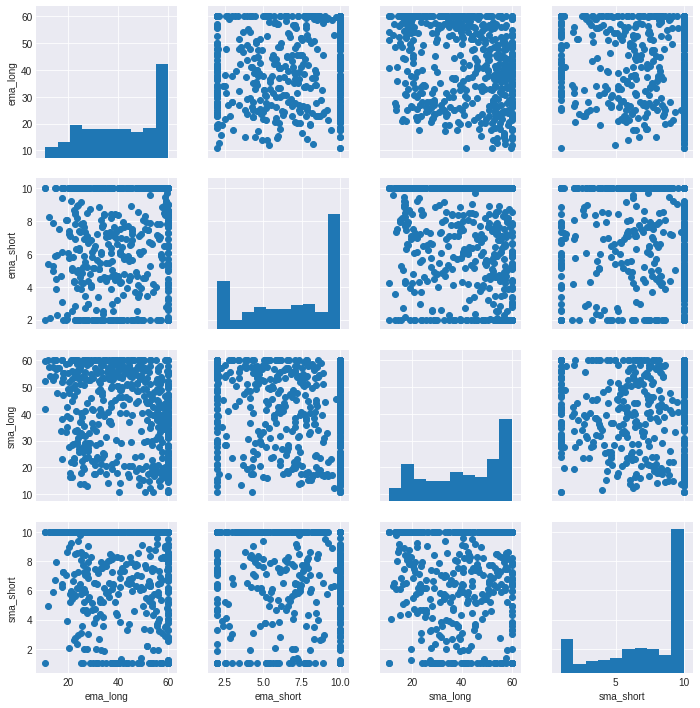

In [9]:
g = sns.PairGrid(boResults)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter);

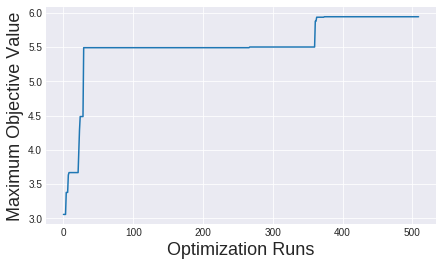

In [30]:
fig = plt.figure(figsize=(7,4))
max_sharpe = [bo.Y[0]]
for sharpe in bo.Y[1:]:
    if sharpe > max_sharpe[-1]:
        max_sharpe.append(sharpe)
    else: max_sharpe.append(max_sharpe[-1])
plt.plot([x for x in range(len(max_sharpe))], max_sharpe)
plt.xlabel("Optimization Runs", fontsize=18)
plt.ylabel("Maximum Objective Value", fontsize=18)
plt.show()

In [13]:
bo.keys

['ema_long', 'ema_short', 'sma_long', 'sma_short']

In [18]:
bo.points_to_csv("results/boSEMA.csv")
param['EMA_long'] = int(round(bo.X[np.argmax(bo.Y)][0]))
param['SMA_short'] = int(round(bo.X[np.argmax(bo.Y)][1]))
param['SMA_long'] = int(round(bo.X[np.argmax(bo.Y)][2]))
param['EMA_short'] = int(round(bo.X[np.argmax(bo.Y)][3]))

In [19]:
param

{'EMA_long': 60, 'EMA_short': 10, 'SMA_long': 17, 'SMA_short': 9}

The result shows that the best is at EMA long = 60 and EMA short = 10. Which are the limits, this test should be repeated with larger limits for EMA. However, because it takes some time to repeat the optimization we will just stick with these parameters. 

The objective value we got is 5.94151 which is much higher than what SMA got 4.08

## Results

We will first run the strategy on the training set. We want to check if the parameters are over fitting on the training set.

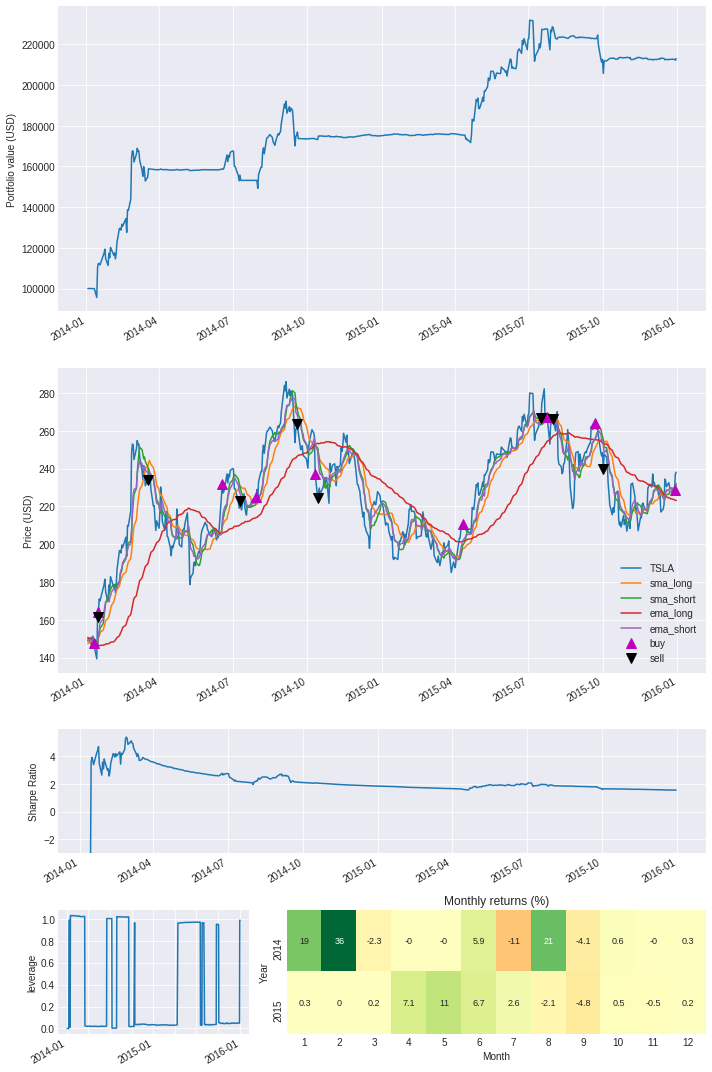

In [21]:
results = run_algorithm(env['train']['start_time'], env['train']['end_time'],
                        initialize=initialize,capital_base=env['capital'], analyze=analyze)

The strategy is doing relatively well on the training data! 

Testing on the testing period of 2016-2017:

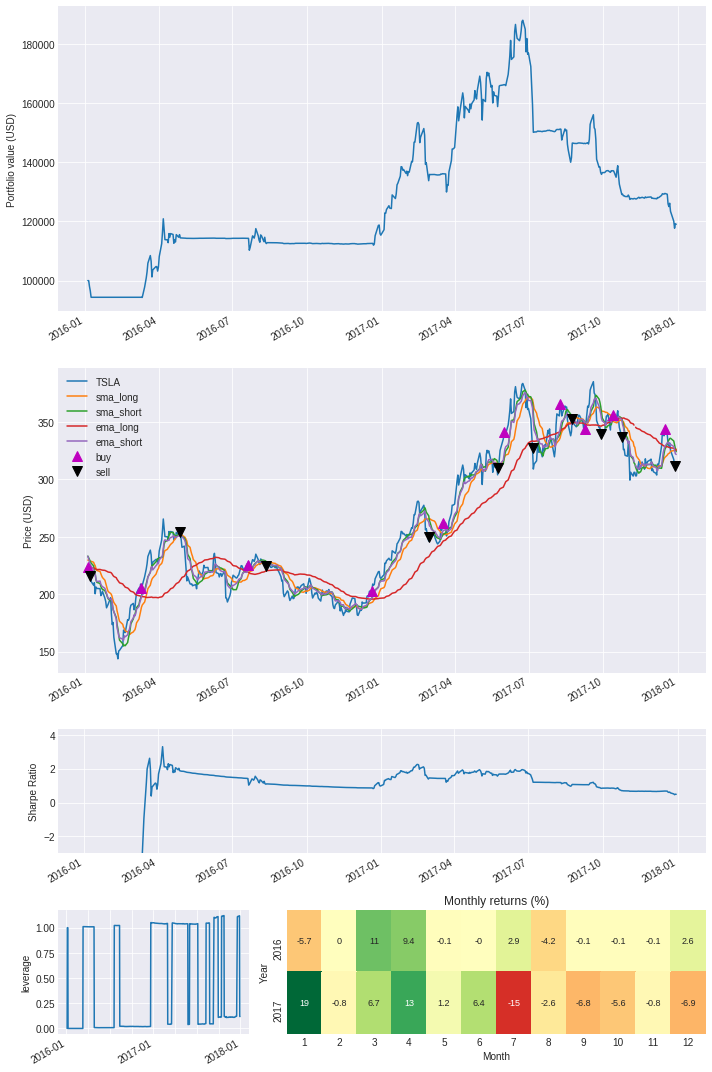

In [22]:
results = run_algorithm(env['test']['start_time'], env['test']['end_time'],
                        initialize=initialize,capital_base=env['capital'], analyze=analyze)

In [23]:
##save the results
results.to_pickle("results/ESMA.pickle")

Unfortunately our strategy is bad! The return at the end is worse than SMA strategy. 
However it is interesting to see the behaviour of the strategy between 2016-04 and 2017-01. Unlike SMA, ESMA was safer in this case and sold the shares and held to it while the price had high votality with a down movement. Similar to SMA the strategy was not able to detect the fast drop after 2017-07. 

Next we will combine our moving average strategies with the regime detection using GMM. We will use it as a safe risk strategy to sell our shares and prevent the trading whenever the model detects we are in high votality regime. 